### Extraindo a média com mne

In [68]:
def extract_avg(ch_names, data):
    ch_types = ['eeg'] * 64
    info = mne.create_info(ch_names=ch_names, sfreq=256, ch_types=ch_types)
    
    subset = data[-1, -1, :, :]
    
    raw = mne.io.RawArray(subset, info)
    raw.drop_channels(['x', 'nd', 'y'])
    
    montage = mne.channels.read_montage('standard_1020')
    raw.set_montage(montage)
    raw, _ = mne.set_eeg_reference(raw, 'average')

    return raw

### Carregando datasets

Assim como foi feito na etapa anterior(load_eeg), precisamos carregar os datasets para realizar o pré-processamento. O trecho a seguir é bem semelhante ao utilizado em load_eeg, tendo como principal diferença a geração da média entre os arquivos das diversas pastas, isso é feito para diminuir a quantidade de entrada no programa mantendo a confiabilidade dos dados e também para formatar os dados de forma que possam ser inseridos nas funções de pré-processamento.

In [69]:
from re import search
import numpy as np
from subprocess import getoutput as gop
import glob
import pandas as pd
import csv
import mne

# identificando pastas
folders = {
    'small': 'dataset/small',
    'large_train': 'dataset/large_train',
    'large_test': 'dataset/large_test',
}

def load_data(dataset):
    ch_names = []
    create_ch_name = False
    
    data_dir = gop('ls {}'.format(folders[dataset])).split('\n')
    # 1ª dimensão dos dados contendo os sujeitos
    subjects = list()
    subjects_alc = list()
    subjects_ctrl = list()
    
    for types in data_dir:
        files = gop('ls {}/{}'.format(folders[dataset], types)).split('\n')
        # 2ª dimensão dos dados contendo as sessões (trials)
        trials = list()
        is_alc = True
        
        for f in files:
            arquivo = open('{}/{}/{}'.format(folders[dataset], types, f))
            text = arquivo.readlines()
            
            alc = search('co2a', text[0])
            ctrl = search('co2c', text[0])
            
            if ctrl:
                is_alc = False
            # 3ª dimensão dos dados contendo os canais (eletrodos)
            chs = list()
            # 4ª dimensão dos dados contendo os valores em milivolts
            values = list()
            for line in text:
                t = search('(?P<ch_name>\w{1,3}) chan \d{1,2}', line)
                p = search('^\d{1,3}\ \w{1,3}\ \d{1,3}\ (?P<value>.+$)', line)
                                    
                if p:
                    values.append(float(p.group('value')))
                # mudou para outro eletrodo
                elif t:
                    if values:
                        chs.append(values)
                        values = list()
                    if not create_ch_name:
                        ch_names.append(t.group('ch_name').lower())
            
            create_ch_name = True
            chs.append(values)
            trials.append(chs)
            arquivo.close()
            
        if is_alc:
            subjects_alc.append(trials)
        else:
            subjects_ctrl.append(trials)
    
    data_alc = np.array(subjects_alc)
    data_ctrl = np.array(subjects_ctrl)
    
    md_alc = extract_avg(ch_names, data_alc)
    md_ctrl = extract_avg(ch_names, data_ctrl)
    
    return data_alc, md_alc, data_ctrl, md_ctrl, ch_names

In [86]:

# identificando pastas
folders = {
    'small': 'dataset/small',
    'large_train': 'dataset/large_train',
    'large_test': 'dataset/large_test',
}

def load_data_by_S(dataset):
    ch_names = []
    create_ch_name = False
    
    data_dir = gop('ls {}'.format(folders[dataset])).split('\n')
    # 1ª dimensão dos dados contendo os sujeitos
    
    subjects_S1_obj = list()
    subjects_S2_match = list()
    subjects_S2_nomatch = list()
    
    for types in data_dir:
        files = gop('ls {}/{}'.format(folders[dataset], types)).split('\n')
        # 2ª dimensão dos dados contendo as sessões (trials)
        trials_S1_obj = list()
        trials_S2_match = list()
        trials_S2_nomatch = list()
        
        is_alc = True
        
        for f in files:
            arquivo = open('{}/{}/{}'.format(folders[dataset], types, f))
            text = arquivo.readlines()
            
            s1_obj = False
            s2_nomatch = False
            s2_match = False
            
            alc = search('co2a', text[0])
            ctrl = search('co2c', text[0])
            
            if ctrl:
                is_alc = False
            # 3ª dimensão dos dados contendo os canais (eletrodos)
            chs_s1 = list()
            chs_s2_nomatch = list()
            chs_s2_match = list()
            # 4ª dimensão dos dados contendo os valores em milivolts
            values = list()
            for line in text:
                t = search('(?P<ch_name>\w{1,3}) chan \d{1,2}', line)
                p = search('^\d{1,3}\ \w{1,3}\ \d{1,3}\ (?P<value>.+$)', line)
                s = search('S\w (?P<s_name>\w{2,9})', line)
                if s:
                    if s.group('s_name') == 'obj':
                        s1_obj = True
                    elif s.group('s_name') == 'match':
                        s2_match = True                    
                    elif s.group('s_name') == 'nomatch':
                        s2_nomatch = True

                if p:
                    values.append(float(p.group('value')))
                # mudou para outro eletrodo
                elif t:
                    if values:
                        if s1_obj:
                            chs_s1.append(values)
                        elif s2_match:
                            chs_s2_match.append(values)
                        elif s2_nomatch:
                            chs_s2_nomatch.append(values)                            
                        values = list()
                    if not create_ch_name:
                        ch_names.append(t.group('ch_name').lower())
            
            create_ch_name = True
            if s1_obj == True:
                chs_s1.append(values)
                trials_S1_obj.append(chs_s1)
            elif s2_match == True:
                chs_s2_match.append(values)
                trials_S2_match.append(chs_s2_match)
            elif s2_nomatch == True:
                chs_s2_nomatch.append(values)
                trials_S2_nomatch.append(chs_s2_nomatch)
            
            arquivo.close()
        subjects_S1_obj.append(trials_S1_obj)
        subjects_S2_match.append(trials_S2_match)
        subjects_S2_nomatch.append(trials_S2_nomatch)
        
        
        data_s1 = np.array(subjects_S1_obj)
        data_s2_match = np.array(subjects_S2_match)
        data_s2_nomatch = np.array(subjects_S2_nomatch)
            
    
    return data_s1, data_s2_match, data_s2_nomatch

### Exibindo dados carregados

Aqui exibimos a forma(shape) dos dados carregados(large train e large test) que representam respectivamente: o número de experimentos, triagens, canais e amostras.
Também exibimos o shape das médias desses dados, como a média é feita entre os experimentos e triagens temos um shape que representa: canais, amostras.

In [88]:
lg_train_alc, md_alc_train, lg_train_ctrl, md_ctrl_train, ch_names = load_data('large_train')
print('**** Large Train ****\n')
print('Alcoólatras: ', lg_train_alc.shape)
print('Controle: ', lg_train_ctrl.shape)
print('\n**** Fim Large Train ****\n')

lg_test_alc, md_alc_test, lg_test_ctrl, md_ctrl_test, ch_names = load_data('large_test')
print('**** Large Test ****\n')
print('Alcoólatras: ', lg_test_alc.shape)
print('Controle: ', lg_test_ctrl.shape)
print('\n**** Fim Large Train ****\n')

chs_s1, chs_s2_match, chs_s2_nomatch = load_data_by_S('large_train')

print('Esperimento S1 obj: ', chs_s1.shape)
print('Esperimento S2 match: ', chs_s2_match.shape)
print('Esperimento S2 nomatch: ', chs_s2_nomatch.shape)

Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying average reference.
Applying a custom EEG reference.
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying average reference.
Applying a custom EEG reference.
**** Large Train ****

Alcoólatras:  (10, 30, 64, 256)
Controle:  (10, 30, 64, 256)

**** Fim Large Train ****

Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying average reference.
Applying a custom EEG reference.
Creating RawArray with float64 data, n_channels=64, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Applying average reference.
Applying a custom EEG reference.
**** Large Test ****

Alcoólatras:  (10, 30, 64, 256)
Controle:  (10, 30, 64, 256)

**** Fim Large Train ****

Esperimento S1 obj:  (20, 10, 64,

### Plotando gráfico nos dois domínios para as médias

Na sequência vamos plotar os dados médios dos eletrodos do arquivo preparado para visualizá-los no domínio do tempo e da frequência. Após visualizar, serão aplicados inicialmente filtros temporais e em seguida filtros espaciais. Aplicamos os filtros para que possamos observar com mais clareza a diferença entre os dados do dataset(alcoólicos e controle) e assim, decidir como proceder para a etapa de classificação.

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
import mne

def graphTimeFrequency(raw, ch_names):
    # Neste primeiro gráfico mostramos o sinal de um eletrodo no domínio do tempo
    plt.plot(np.linspace(0, 1, 256), raw.get_data()[0])
    plt.xlabel('tempo (s)')
    plt.ylabel('Dados EEG (mV/cm²)')

    # Aqui mostramos todos os 61 eletrodos que representam dados EEG
    raw.plot_psd()
    print()

*** Large Train ****

ALCOOÓLATRAS
Effective window size : 1.000 (s)


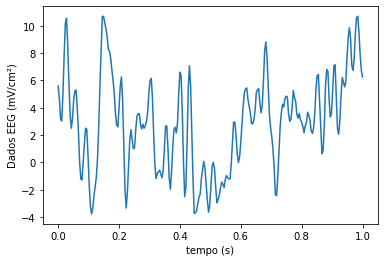

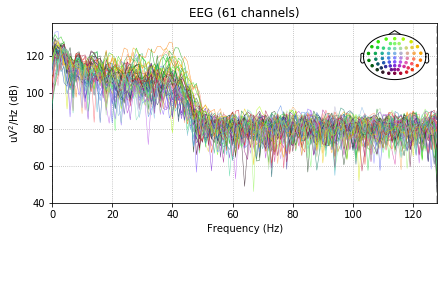


CONTROLE
Effective window size : 1.000 (s)


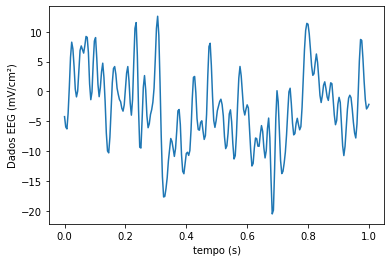

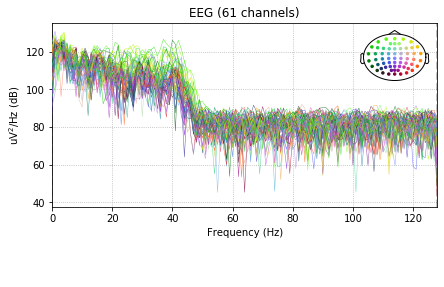


*** Fim Large Train ****

*** Large Test ****

ALCOOÓLATRAS
Effective window size : 1.000 (s)


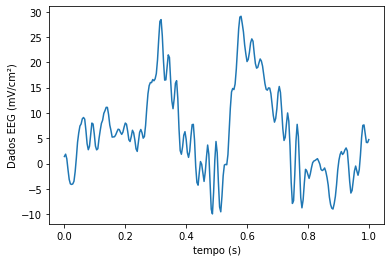

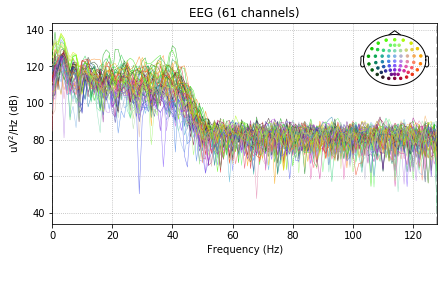


CONTROLE
Effective window size : 1.000 (s)


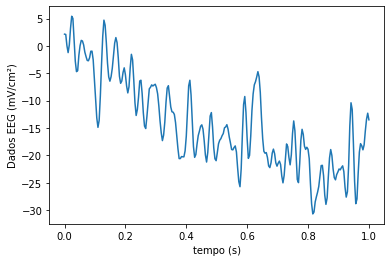

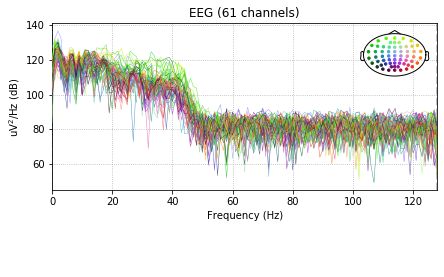


*** Fim Large Test ****



In [15]:
print("*** Large Train ****\n")
print("ALCOOÓLATRAS")
graphTimeFrequency(md_alc_train, ch_names)
print("CONTROLE")
graphTimeFrequency(md_ctrl_train, ch_names)
print("*** Fim Large Train ****\n")

print("*** Large Test ****\n")
print("ALCOOÓLATRAS")
graphTimeFrequency(md_alc_test, ch_names)

print("CONTROLE")
graphTimeFrequency(md_ctrl_test, ch_names)
print("*** Fim Large Test ****\n")

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (1.652 sec)

Effective window size : 1.000 (s)


<ipython-input-19-76ecbc633c4e>:6: RuntimeWarning: filter_length (1691) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  raw2.notch_filter(np.arange(60, 121, 60), fir_design='firwin')
<ipython-input-19-76ecbc633c4e>:7: RuntimeWarning: filter_length (423) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  raw2.filter(5., 50., fir_design='firwin')


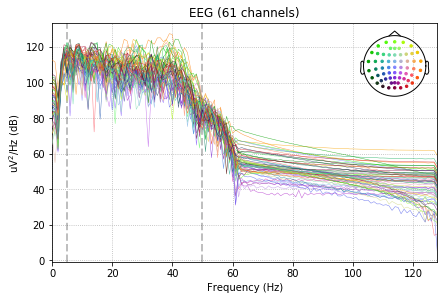


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 3.35 Hz
- Upper transition bandwidth: 3.35 Hz
- Filter length: 255 samples (0.996 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 3.35 Hz (-6 dB cutoff frequency: 3.33 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 255 samples (0.996 sec)

Effective window size : 1.000 (s)


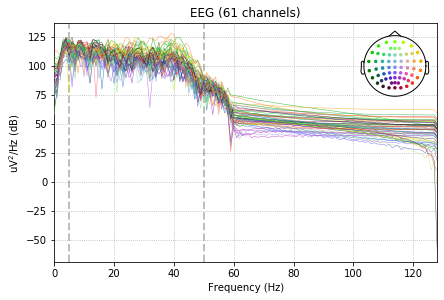


(1, 256)
Creating RawArray with float64 data, n_channels=1, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
['p3', 'p4', 'pz', 'p8', 'p7', 'po2', 'po1', 'p5', 'p6', 'po7', 'po8', 'poz', 'p2', 'p1']
Applying a custom EEG reference.
(256,)
<RawArray  |  None, n_channels x n_times : 61 x 256 (1.0 sec), ~288 kB, data loaded>


Text(0, 0.5, 'Dados EEG (mV/cm²)')

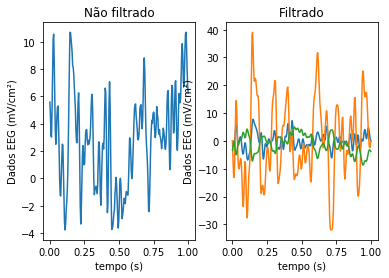

In [19]:
#---------------------EDITAR AINDA

from copy import deepcopy

raw2 = deepcopy(md_alc_train)
raw2.notch_filter(np.arange(60, 121, 60), fir_design='firwin')
raw2.filter(5., 50., fir_design='firwin')
raw2.plot_psd(area_mode='range')
print()

#----------------------

raw3 = deepcopy(md_alc_train)
raw3.notch_filter(np.arange(60, 121, 60), fir_design='firwin', trans_bandwidth=6.7, filter_length='996ms')
raw3.filter(5., 50., fir_design='firwin', l_trans_bandwidth=3.35, filter_length='996ms')
raw3.plot_psd(area_mode='range')

fig = plt.figure()

ax = fig.add_subplot(1, 2, 1)
ax.plot(np.linspace(0, 1, 256), md_alc_train.get_data()[0])
plt.title('Não filtrado')
plt.xlabel('tempo (s)')
plt.ylabel('Dados EEG (mV/cm²)')

ax = fig.add_subplot(1, 2, 2)
ax.plot(np.linspace(0, 1, 256), raw3.get_data()[0])
plt.title('Filtrado')
plt.xlabel('tempo (s)')
print()

#----------------------

from sklearn.decomposition import PCA

pca = PCA(n_components=1)
projected = pca.fit_transform(raw3.get_data().T).T
print(projected.shape)

info = mne.create_info(ch_names=('x',), sfreq=256)
new_raw = mne.io.RawArray(projected, info)

plt.plot(np.linspace(0, 1, 256), new_raw.get_data()[0])
plt.xlabel('tempo (s)')
plt.ylabel('Dados EEG (mV/cm²)')

#--------------------------

from mne import set_eeg_reference as car

chs_P = [c for c in md_alc_train.ch_names if c[0] == 'p']
print(chs_P)

inst, data = car(md_alc_train, ref_channels=chs_P)
print(data.shape)
print(inst)
plt.plot(np.linspace(0, 1, 256), data)
plt.xlabel('tempo (s)')
plt.ylabel('Dados EEG (mV/cm²)')

#-----------------------------